# Pole balancing

We consider the classic pole balancing task due to Sutton & Barto (see also lecture notes). 

Each state is determined by four values:

|Num |    Observation |              Min  |                   Max |
|----------|--------|-------------|---------------|
|0|       Cart Position|             -4.8 |                   4.8|
|1|       Cart Velocity      |       -Inf         |           Inf|
|2|       Pole Angle        |        -0.418 rad (-24 deg) |   0.418 rad (24 deg)|
|3|       Pole Angular Velocity |    -Inf           |         Inf|

There are only two actions possible

|Num   |Action|
|-------|--------|
|0|  Push cart to the left|
|1|  Push cart to the right|


The pole balancing task is implemented in the package <code>gymnasium</code> that you need to install. The package provides a framework for reinforcement tasks and a number of fun tasks. Check it out here: https://gymnasium.farama.org/

In [1]:
## install gymnasium in colab via
# !pip install gymnasium

import gymnasium as gym

We initialise the task with <code>gym.make</code>. Unfortunately, it's not easy to get information on the task. We only get to the documentation when we find out where explicitely the task is defined. (<code>help(env)</code> does **not** work.)

In [2]:
env=gym.make("CartPole-v1")
help(gym.envs.classic_control.cartpole)

Help on module gymnasium.envs.classic_control.cartpole in gymnasium.envs.classic_control:

NAME
    gymnasium.envs.classic_control.cartpole

DESCRIPTION
    Classic cart-pole system implemented by Rich Sutton et al.
    Copied from http://incompleteideas.net/sutton/book/code/pole.c
    permalink: https://perma.cc/C9ZM-652R

CLASSES
    gymnasium.core.Env(typing.Generic)
        CartPoleEnv
    gymnasium.experimental.vector.vector_env.VectorEnv(typing.Generic)
        CartPoleVectorEnv
    
    class CartPoleEnv(gymnasium.core.Env)
     |  CartPoleEnv(render_mode: Optional[str] = None)
     |  
     |  ## Description
     |  
     |  This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson in
     |  ["Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem"](https://ieeexplore.ieee.org/document/6313077).
     |  A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track.
     |

From the documentation we learn that there are two actions possible, and we introduce variables to better distinguish between the two.

In [3]:
# we define two variable so that we can better distinguish between the actions
push_left=0
push_right=1

Next, reset the environment and observe the starting state.

In [4]:
state,info=env.reset()
state,info

(array([0.04234096, 0.01475053, 0.03324237, 0.03756815], dtype=float32), {})

As return value, we get a starting state, an array with cart position, cart velocity, pole angle and pole angular velocity, as well as a dictionary with additional information. (In the pole task the dictionary is always empty, I beliebe. We'll ignore it.)

Let's choose an action and perform a <code>env.step</code>. 

In [5]:
new_state, reward, terminated, truncated, info = env.step(push_left)
new_state,reward,terminated,truncated,info

(array([ 0.04263597, -0.18083195,  0.03399374,  0.34055126], dtype=float32),
 1.0,
 False,
 False,
 {})

What are the return values? <code>new_state</code> and <code>reward</code> are self-explanatory. <code>terminated</code> tells us whether a terminal state was reached, and <code>truncated</code> only becomes true if the episode ended because we set an external time limit or some other termination constraint. Again <code>info</code> will be an empty dictionary that we discard.

## Let's try out a simple strategy

We set up a simple strategy: Whenever the pole leans to the left, push left; whenever it leans to the right, push right. We then test the strategy by playing 1000 times and computing the mean total reward. We set the maximum length of an episode to 300: If you can balance the pole for that long you probably can do so indefinitely. To cap episode length we use a mechanism provided by the <code>gymnasium</code> package: a wrapper that we apply to the environment. One important point: if the episode ends because the time limit / step limit has been reached, the environment does not issue a <code>terminated</code> signal but a <code>truncated</code> signal.

In [7]:
def basic_policy(state):
    if len(state)<3:
        print(state)
    angle=state[2]
    return push_left if angle <0 else push_right

# the time limit wrapper
from gymnasium.wrappers import TimeLimit

def play_single_episode(policy,env,max_episode_length=300):
    total_reward=0
    env=TimeLimit(env,max_episode_length)
    state,info=env.reset()
    terminated=False
    truncated=False
    while not terminated and not truncated:
        action=policy(state)
        state,reward,terminated,truncated,info=env.step(action)
        total_reward+=reward
    return total_reward

def play_many_episodes(policy,env,repeats,max_episode_length=300):
    total_rewards=[]
    for i in range(repeats):
        total_rewards.append(play_single_episode(policy,env,max_episode_length))
    return sum(total_rewards)/len(total_rewards)

play_many_episodes(basic_policy,env,1000)

41.926

Could be better! Can you come up with a better policy? If you want to experiment, you should consult the [documentation](https://gymnasium.farama.org/), where, in particular, you can find out how to visualise episodes. 

To see what's happening, let's run and record a single episode.

In [9]:
policy=basic_policy
total_reward=0
state,info=env.reset()
states=[]
actions=[]
terminated=False
truncated=False
while not terminated and not truncated:
    action=policy(state)
    states.append(state)
    actions.append(action)
    state,reward,terminated,truncated,info=env.step(action)
    total_reward+=reward

Next, we plot the states and actions as a function of time.

Text(1.01, 0.5, 'action')

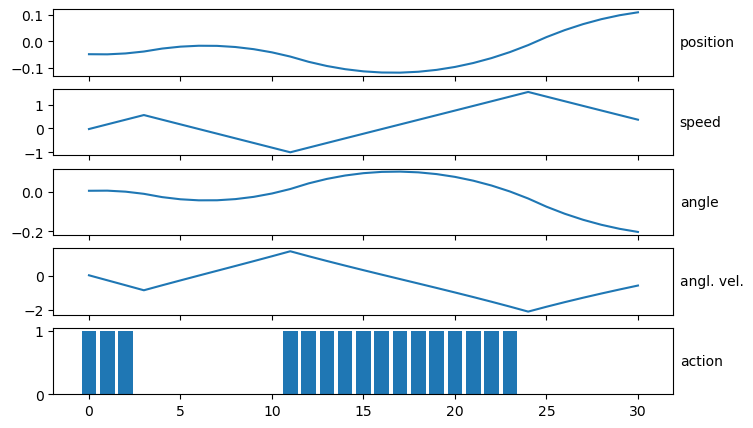

In [41]:
import matplotlib.pyplot as plt
import numpy as np

fig,axs=plt.subplots(5,1,figsize=(8,5),sharex=True)
titles=["position","speed","angle","angl. vel."]
for ax,state_entries,title in zip(axs,np.array(states).T,titles):
    ax.plot(state_entries)
    ax.text(1.01, 0.5, title, rotation=0, ha='left', va='center',transform=ax.transAxes)

axs[-1].bar(range(len(actions)),actions)
axs[-1].text(1.01, 0.5, "action", rotation=0, ha='left', va='center',transform=axs[-1].transAxes)


The relentless repetition of the same action pushes the angular velocity to large values so that ultimately the pole topples over.